# Figure 7
An illustration of the SuRRF fitting procedure.

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from fig7code import *

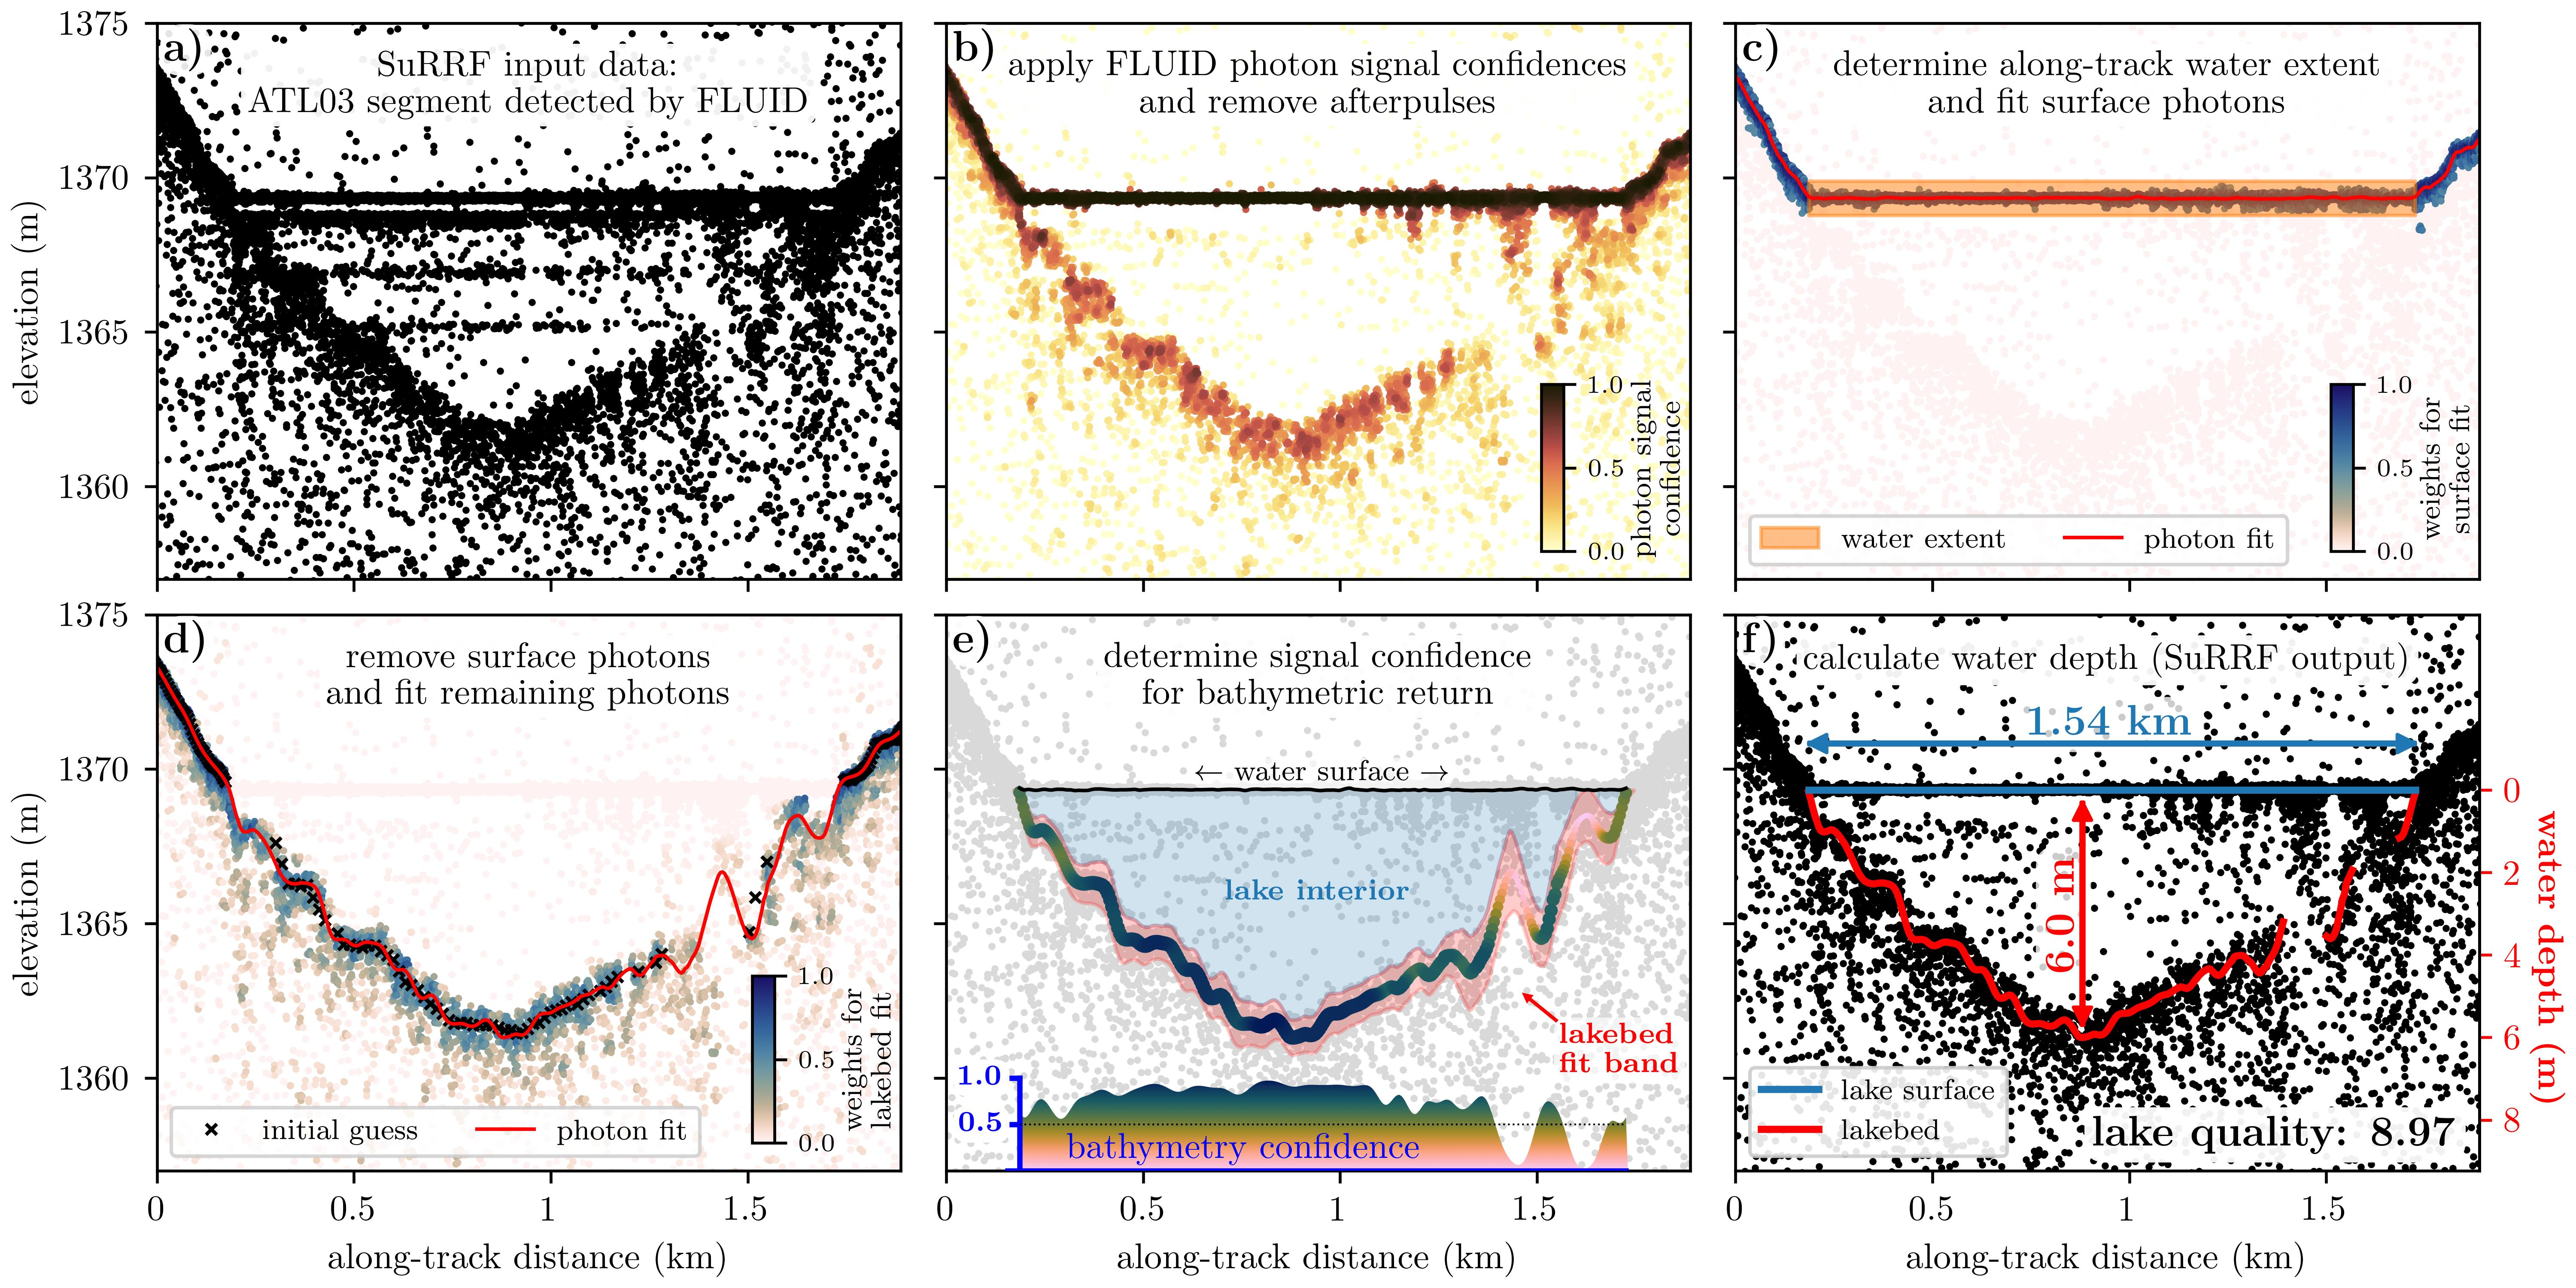


LAKE INFO: 
  granule_id:            ATL03_20200713115804_02770803_006_01.h5
  RGT:                   277
  GTX:                   GT2L
  beam:                  3 (strong)
  acquisition time:      2020-07-13T12:00:21Z
  center location:       (48.51341W, 68.19226N)
  ice sheet:             GrIS
  melt season:           2020
  SuRRF lake quality:    8.97
  surface_elevation:     1369.33 m
  maximum water depth:   6.00 m
  water surface length:  1.54 km



In [2]:
filename = 'data/lake_surrf_explainer.h5'
plotname = '../figures/fig07-surrf_explainer.jpg'

lk = dictobj(read_melt_lake_h5(filename))

# add the additional SuRRF illustration data
with h5py.File(filename) as f:
    lk.init_guess = pd.DataFrame({key: np.array(f['init_guess'][key][()]) for key in ['xatc', 'h']})
    lk.surf_weights =  pd.DataFrame({key: np.array(f['ph_tofit_surf'][key][()]) for key in ['xatc', 'h', 'snr']})
    lk.bed_weights =  pd.DataFrame({key: np.array(f['ph_tofit_bed'][key][()]) for key in ['xatc', 'h', 'snr']})

# adjust the along-track distances so that the plot starts at zero
plot_xatc_lim = (110, 1999)
plots_ylim = (1357, 1375)
lk.photon_data.xatc -= plot_xatc_lim[0]
lk.depth_data.xatc -= plot_xatc_lim[0]
lk.init_guess.xatc -= plot_xatc_lim[0]
lk.surf_weights.xatc -= plot_xatc_lim[0]
lk.bed_weights.xatc -= plot_xatc_lim[0]
df = lk.photon_data.copy()
dfd = lk.depth_data.copy()

# calculate the along-track values of depth estimates to be shown, based on confidence threshold
bathy_conf_thresh = 0.5
isdepth = dfd.depth>0
bed = dfd.h_fit_bed.copy()
surffit = dfd.h_fit_surf.copy()
bed[~isdepth] = np.nan
surffit[~isdepth] = np.nan
bed[dfd.conf < bathy_conf_thresh] = np.nan
surf = np.ones_like(dfd.xatc) * lk.surface_elevation
surf[~isdepth] = np.nan
surf_only = surf[~np.isnan(surf)]
bed_only = bed[(~np.isnan(surf)) & (~np.isnan(bed))]
xatc_surf = np.array(dfd.xatc)[~np.isnan(surf)]
xatc_bed = np.array(dfd.xatc)[(~np.isnan(surf)) & (~np.isnan(bed))]
xatc = np.array(dfd.xatc)
xatc[~isdepth] = np.nan

# figure settings
plt.rcParams.update({
    'font.size': 10,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})

fig, axs = plt.subplots(figsize=[10,5], ncols=3, nrows=2)
axs = axs.flatten()

##################################################################################
# panel a) plot the raw input data
ax = axs[0]
ax.scatter(df.xatc, df.h, s=1, c='k')

##################################################################################
# panel b) remove afterpulses, plot with confidences
ax = axs[1]
df = df[df.prob_afterpulse < np.random.uniform(0,1,len(df))] # fully remove afterpulses now
dfsnr = df.sort_values(by='snr')
scatt = ax.scatter(dfsnr.xatc, dfsnr.h, s=1, c=dfsnr.snr, cmap=cmc.lajolla)
cax = ax.inset_axes([0.8, 0.05, 0.03, 0.3])
cbar = plt.colorbar(scatt, cax=cax, orientation='vertical')
cbar.set_label('photon signal\nconfidence', fontsize=8, labelpad=1.5)
cax.tick_params(axis='both', which='major', labelsize=7)

##################################################################################
# panel c) plot the surface fit weights, plot water extent and surface fit
ax = axs[2]
ax.scatter(df.xatc, df.h, s=1, c=df.snr*0, cmap=cmc.lapaz_r, vmin=0, vmax=1) # show zero weight photons
scatt = ax.scatter(lk.surf_weights.xatc, lk.surf_weights.h, s=1, c=lk.surf_weights.snr, cmap=cmc.lapaz_r, vmin=0, vmax=1)
cax = ax.inset_axes([0.8, 0.05, 0.03, 0.3])
cbar = plt.colorbar(scatt, cax=cax, orientation='vertical')
cbar.set_label('weights for\nsurface fit', fontsize=8, labelpad=1.5)
cax.tick_params(axis='both', which='major', labelsize=7)
h1, = ax.plot(dfd.xatc, dfd.h_fit_surf, color='r', ls='-', lw=1, label='photon fit')
h2 = ax.fill_between(dfd.xatc[isdepth], lk.surface_elevation-0.55, lk.surface_elevation+0.55, color='C1', alpha=0.5, label='water extent')
ax.legend(handles = [h2,h1], loc='lower left', fontsize=8, ncols=2)

##################################################################################
# panel d) plot the lakebed fit weights, plot the inital guess and the final lakebed fit
ax = axs[3]
ax.scatter(df.xatc, df.h, s=1, c=df.snr*0, cmap=cmc.lapaz_r, vmin=0, vmax=1) # show zero weight photons here
scatt = ax.scatter(lk.bed_weights.xatc, lk.bed_weights.h, s=1, c=lk.bed_weights.snr, cmap=cmc.lapaz_r, vmin=0, vmax=1)
cax = ax.inset_axes([0.8, 0.05, 0.03, 0.3])
cbar = plt.colorbar(scatt, cax=cax, orientation='vertical')
cbar.set_label('weights for\nlakebed fit', fontsize=8, labelpad=1.5)
cax.tick_params(axis='both', which='major', labelsize=7)
hdl3, = ax.plot(lk.init_guess.xatc, lk.init_guess.h, ls='' , marker='x', color='k', markersize=3, label='initial guess', lw=0.0)
hdl1, = ax.plot(dfd.xatc, dfd.h_fit_bed, color='r', ls='-', lw=1, label='photon fit')
ax.legend(handles=[hdl3, hdl1], loc='lower left', fontsize=8, ncols=2)

##################################################################################
# panel e) plot the lakebed fit confidences in inset axes and color lakebed fit based on the gradient "colorbar"
ax = axs[4]
ax.scatter(df.xatc, df.h, s=1, color=[0.85]*3)
dfconf = dfd[isdepth].sort_values(by='conf')
ax.scatter(dfconf.xatc, dfconf.h_fit_bed, s=dfconf.conf*10, c=dfconf.conf, cmap=cmc.batlow_r, zorder=100)
confs = dfd.conf.copy()
confs[~isdepth] = 0
polygon = ax.fill_between(dfd.xatc, 3*confs+1357, 1357, color='none', alpha=0.3)
verts = np.vstack([p.vertices for p in polygon.get_paths()])
gradient = ax.imshow(np.linspace(0, 1, 256).reshape(-1, 1), cmap=cmc.batlow, aspect='auto',
                      extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()], zorder=10)
gradient.set_clip_path(polygon.get_paths()[0], transform=ax.transData)
axcol = 'b'
ax.text(0.4, 0.01, r'bathymetry confidence', transform=ax.transAxes, ha='center', va='bottom', fontsize=10, color=axcol, zorder=11)
ax.plot([np.nanmin(dfd.xatc[isdepth]), np.nanmax(dfd.xatc[isdepth])], [1357]*2, color=axcol, zorder=11)
ax.plot([np.nanmin(dfd.xatc[isdepth])]*2, [1357, 1357+3], color=axcol, zorder=11)
xtcks = [0, 0.5, 1]
for xtck in xtcks:
    xt = np.nanmin(dfd.xatc[isdepth])-30
    yt = 1357+xtck*3
    ax.plot([xt, xt+30], [yt]*2, color=axcol, zorder=11)
    if xtck == 0.5:
        ax.plot([xt+30,np.nanmax(dfd.xatc[isdepth])],[yt]*2, color='k', lw=0.5, ls=':', zorder=500)
    if xtck != 0:
        ax.text(xt-10, yt, r'\textbf{%.1f}'%xtck, fontsize=8, zorder=11, color=axcol, ha='right', va='center',
                bbox=dict(facecolor='white', alpha=0.98, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0))
hdl = ax.fill_between(dfd.xatc, dfd.h_fit_bed+2*dfd.std_bed+0.25, dfd.h_fit_surf, color='C0', alpha=0.2, label='lake interior',
                     where=dfd.h_fit_bed+3*dfd.std_bed+0.25 < lk.surface_elevation)
ax.text(0.5, 0.5, r'\textbf{lake interior}', color='C0', fontsize=8, transform=ax.transAxes, ha='center', va='center')
hdl4 = ax.fill_between(dfd.xatc, dfd.h_fit_bed-2*dfd.std_bed-0.25, np.clip(dfd.h_fit_bed+2*dfd.std_bed+0.25, None, lk.surface_elevation), 
                       color='r', alpha=0.2, label='fit range', where=dfd.h_fit_bed-2*dfd.std_bed-0.25<lk.surface_elevation)
ax.annotate(r'\textbf{lakebed}'+'\n'+r'\textbf{fit band}', xy=[1461.6249-plot_xatc_lim[0], 1362.7628], 
            xytext=[1557.60-plot_xatc_lim[0], 1361.77], fontsize=8, color='r', ha='left', va='top',
            arrowprops=dict(width=1, headwidth=3, headlength=3, color='r', shrink=0.0, lw=0), 
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0))
hdl2, = ax.plot(xatc, dfd.h_fit_surf, color='k', lw=1, ls='-', label='water surface', zorder=1000)
ax.text(np.nanmean(xatc), lk.surface_elevation+0.3, r'$\leftarrow$ water surface $\rightarrow$', fontsize=8, 
        ha='center', va='baseline', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.1,rounding_size=0.5', lw=0))

##################################################################################
# panel f) plot the final output data
ax = axs[5]
ax.scatter(df.xatc, df.h, s=1, c='k')
hdl2, = ax.plot(dfd.xatc, bed, color='r', lw=2, label='lakebed')
hdl1, = ax.plot(dfd.xatc, surf, color='C0', lw=2, label='lake surface')
ax.legend(handles = [hdl1, hdl2], loc='lower left', fontsize=8, framealpha=0.9)

# annotate the length of surface
arr_y = lk.surface_elevation+lk.max_depth*0.25
x_start = np.min(xatc_surf)
x_end = np.max(xatc_surf)
x_mid = (x_end + x_start) / 2
len_surf_m = np.floor((x_end-x_start)/10)*10
len_surf_km = len_surf_m/1000
arr_x1 = x_mid - len_surf_m / 2
arr_x2 = x_mid + len_surf_m / 2
ax.annotate('', xy=(arr_x1, arr_y), xytext=(arr_x2, arr_y),
                     arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='C0'),zorder=1000)
ax.annotate('', xy=(arr_x2, arr_y), xytext=(arr_x1, arr_y),
                     arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='C0'),zorder=1000)
ax.text(x_mid, arr_y, r'\textbf{%.2f km}' % len_surf_km, fontsize=12, ha='center', va='bottom', color='C0', fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0))

# annotate the max depth based on the chosen threshold
y_low = np.min(bed_only)
y_up = lk.surface_elevation
arr_x = xatc_bed[np.argmin(bed_only)]
y_len = y_up - y_low
y_mid = (y_up + y_low) / 2
arr_len = y_len * 0.9
arr_y1 = y_mid + arr_len / 2
arr_y2 = y_mid - arr_len / 2
ref_index = 1.336
dep_round = np.round(y_len / ref_index, 1)
ax.annotate('', xy=(arr_x, arr_y2), xytext=(arr_x, arr_y1),
                     arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='r'),zorder=1000)
ax.annotate('', xy=(arr_x, arr_y1), xytext=(arr_x, arr_y2),
                     arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='r'),zorder=1000)
ax.text(arr_x, y_mid, r'\textbf{%.1f m}' % dep_round, fontsize=12, ha='right', va='center', color='r', fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.8, lw=0, boxstyle='round,pad=0.2,rounding_size=0.5'), rotation=90)

# print the lake quality 
ax.text(0.97, 0.03, r'\textbf{lake quality: %.2f}' % lk.lake_quality, transform=ax.transAxes, ha='right', va='bottom', fontsize=12,
       bbox=dict(facecolor='white', alpha=0.95, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0))

# add secondary axis for the water depth, adjusted by the refractive index
h0 = lk.surface_elevation
refract_idx = 1.336
def h2d(h):
    return (h0 - h) / refract_idx
def d2h(d):
    return h0 - d * refract_idx 
dax = ax.secondary_yaxis(location='right', functions=(h2d, d2h))
dax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ypos_label = 0.38
dax.set_ylabel(r'\textbf{water depth (m)}', rotation=-90, color='r', fontsize=10, labelpad=12, y=ypos_label)
max_depth = 8
ylm = ax.get_ylim()
xlm = ax.get_xlim()
ax.plot([2000]*2, [h0, d2h(max_depth)], 'r-', lw=3, zorder=100000, solid_capstyle='butt')
yticks = np.arange(0, max_depth+0.01, 2)
dax.set_yticks(yticks)
dax.tick_params(axis='y', colors='red')

# add titles to all panels
titles = [
    'SuRRF input data:\nATL03 segment detected by FLUID',
    'apply FLUID photon signal confidences\nand remove afterpulses',
    'determine along-track water extent\n and fit surface photons',
    'remove surface photons\nand fit remaining photons',
    'determine signal confidence\nfor bathymetric return',
    'calculate water depth (SuRRF output)'
]

# apply axis limits, and show ticks/labels only on the bottom left because all figures share the same axes
plots_xlim = np.array(plot_xatc_lim) - plot_xatc_lim[0]
for i, ax in enumerate(axs):
    ax.set_xlim(plots_xlim)
    ax.set_ylim(plots_ylim)
    kwargs = {'bottom':True, 'left':True, 'labelbottom':False, 'labelleft':False}
    if i%3 == 0:
        kwargs['left'] = True
        kwargs['labelleft'] = True
        ax.set_ylabel('elevation (m)')
    if i >= 3:
        kwargs['bottom'] = True
        kwargs['labelbottom'] = True
        xtcks = ax.get_xticks()
        ax.set_xticklabels(['%g'%(xt/1000) for xt in xtcks])
        ax.set_xlabel('along-track distance (km)')
    ax.tick_params(axis='both',which='both',**kwargs)

    # panel titles
    ax.text(0.5, 0.95, titles[i], transform=ax.transAxes, ha='center', va='top', fontsize=10,
               bbox=dict(facecolor='white', alpha=0.95, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0))

    # panel labels
    ax.text(0.01, 0.99, r'\textbf{%s)}' % chr(ord('a') + i), transform=ax.transAxes, ha='left', va='top', fontsize=12,
           bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=.1,rounding_size=0.5', lw=0))

fig.tight_layout(pad=0.3)

# save the figure
fig.savefig(plotname, dpi=600)
plt.close(fig)

# show plot and print info
display(Image(plotname))
print_lake_info(filename)